In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns


df = pd.read_csv("Iris.csv").drop(["Id"], axis=1)

df = df.map(lambda element: pd.NA if element in ['', ' ', None] else element)
undefined_data = round((df.isna().any(axis=1).sum() / df.size) * 100, 3)

class_names = df["Species"].unique().tolist()
objects_in_classes = df["Species"].value_counts().to_list()

col_labels = ["Size", "Features", "Classes"] + class_names + ["Undefined objects"]
cells = [[df["Species"].size, 4, len(class_names)] + objects_in_classes + [undefined_data]]
dataset_info = pd.DataFrame(cells, columns=col_labels)

print(dataset_info)

   Size  Features  Classes  Iris-setosa  Iris-versicolor  Iris-virginica  \
0   150         4        3           50               50              50   

   Undefined objects  
0                0.0  


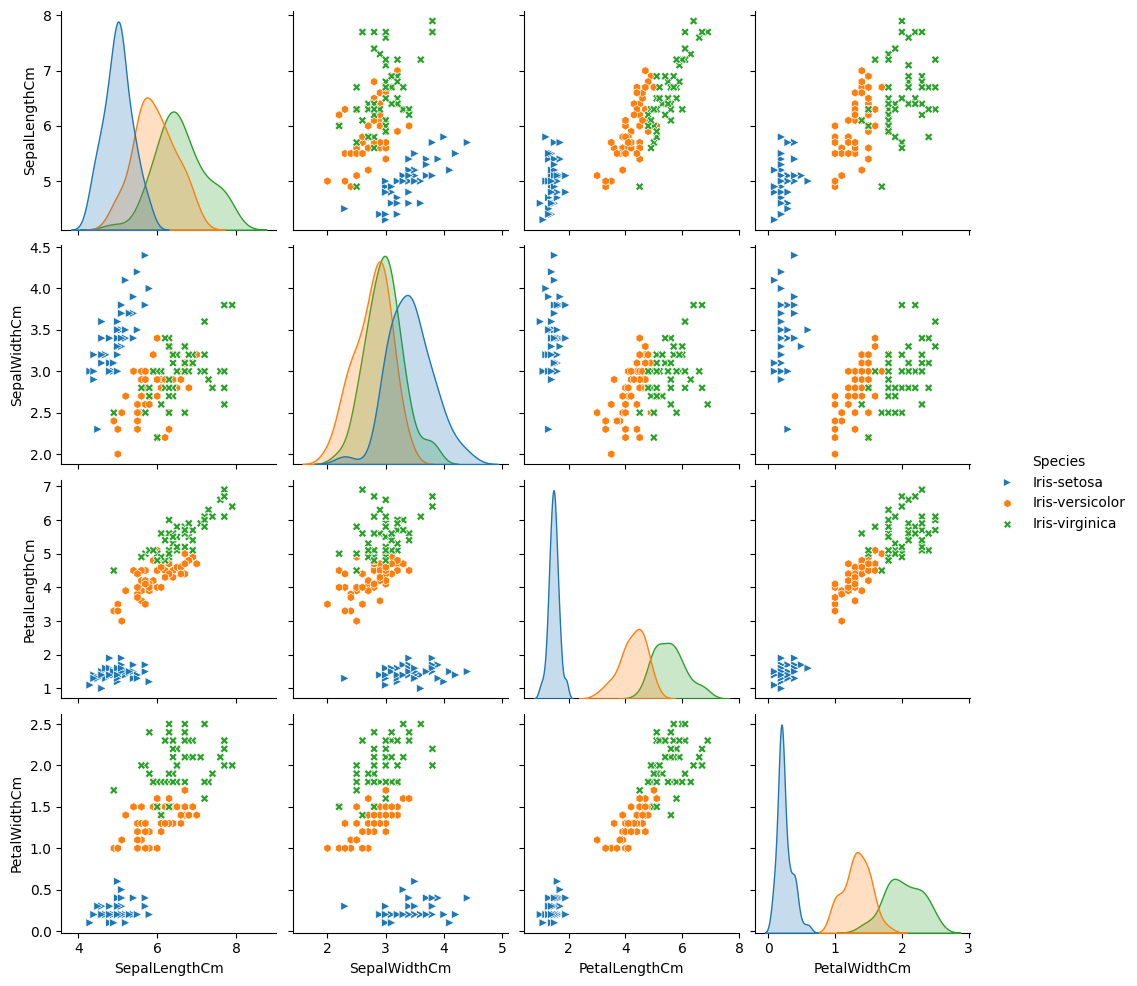

In [20]:
class_markers = list()
for i, class_name in enumerate(class_names):
    class_markers.append(MarkerStyle.filled_markers[(i + 1) * 5])
    
sns.pairplot(df, hue="Species", markers=class_markers)
plt.show()

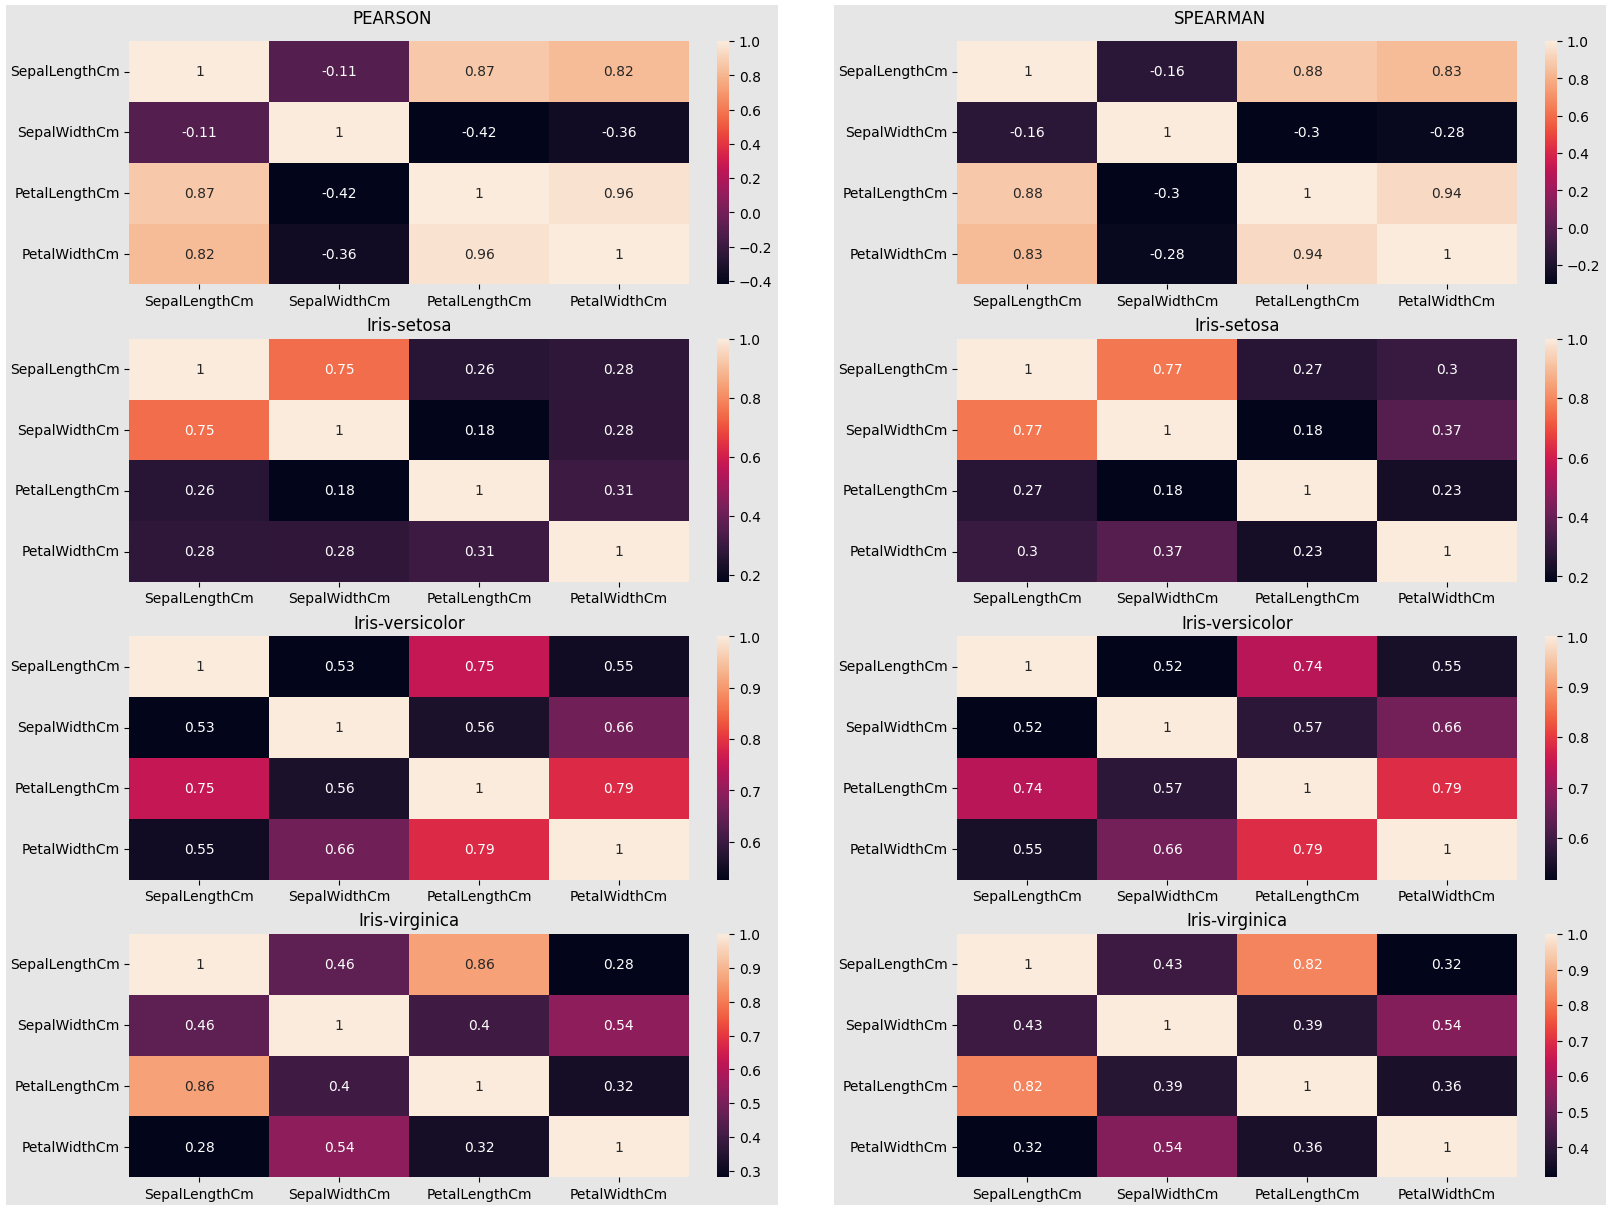

In [24]:
def draw_corr_matrix(df: pd.DataFrame, ax: plt.Axes, method: str):
    corr = df.corr(method)
    sns.heatmap(corr, annot=True, ax=ax)


def draw_corr_matrices(all_objects: pd.DataFrame, objects_by_class: dict, class_names: list) -> plt.Figure:
    fig = plt.figure(layout="constrained", figsize=[16, 12])
    subfigs = fig.subfigures(1, 2, wspace=0.07)
    for i, method in enumerate(["pearson", "spearman"]):
        subfigs[i].suptitle(method.upper())
        subfigs[i].set_facecolor("0.9")
        axs = subfigs[i].subplots(4, 1)
        draw_corr_matrix(all_objects, axs[0], method)
        for j, class_name in enumerate(class_names):
            draw_corr_matrix(objects_by_class[class_name], axs[j + 1], method)
            axs[j + 1].set_title(class_name)
    return fig


all_objects = df.drop(["Species"], axis=1)
objects_by_class = dict()
for class_name in class_names:
    objects_by_class[class_name] = df[df["Species"] == class_name].drop(["Species"], axis=1)

corr_matrices_fig = draw_corr_matrices(all_objects, objects_by_class, class_names)
plt.show()

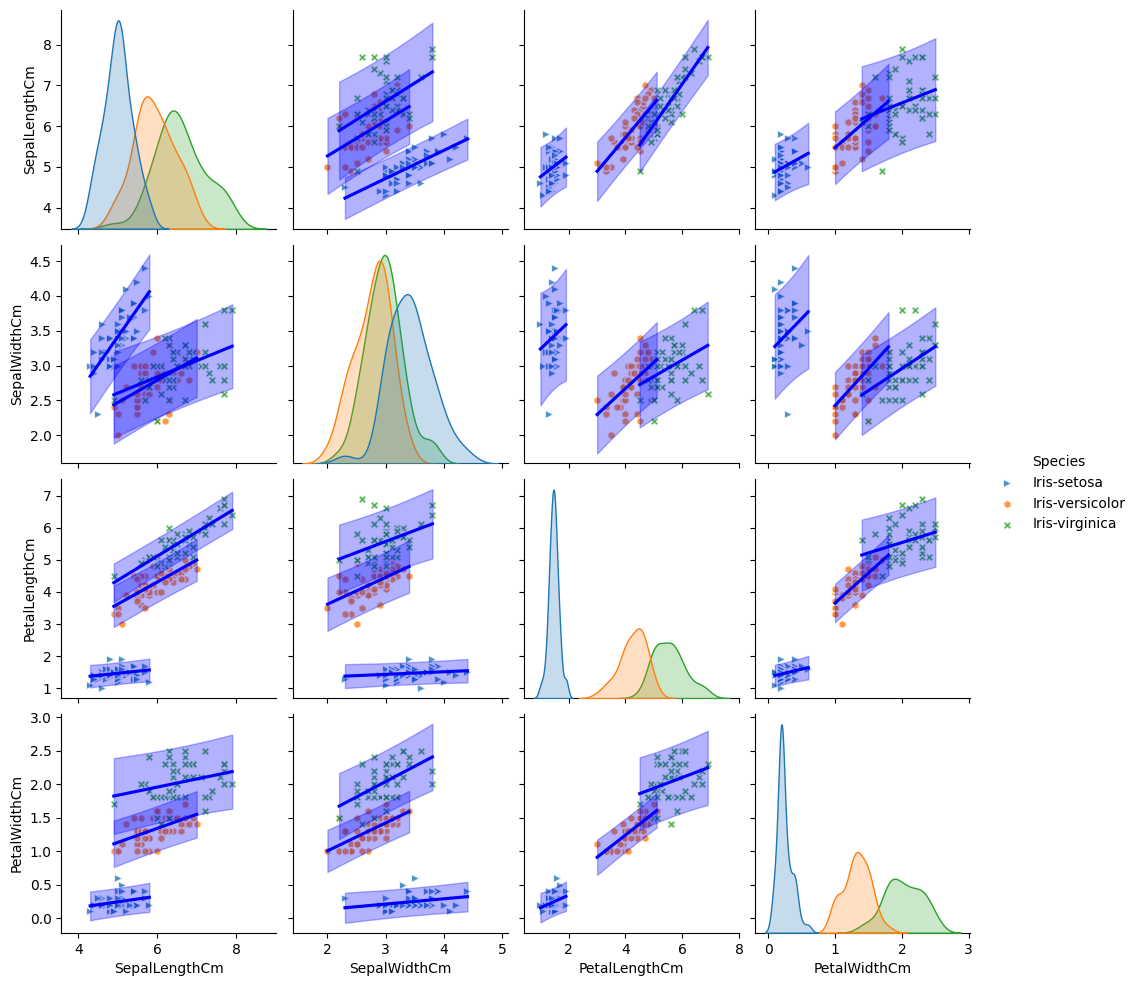

In [22]:
reg_fig = sns.pairplot(df, hue="Species", kind="reg", 
                       plot_kws=dict(ci=None, x_ci="ci", line_kws=dict(color="b"), 
                                     scatter_kws=dict(edgecolor="white")), 
                                     markers=class_markers).figure

axs = reg_fig.get_axes()
feature_names = df.columns.to_list()[:-1]
for i, feature_name in enumerate(feature_names):
    for j, next_feature_name in enumerate(feature_names):
        if i != j:
            for class_name in class_names:
                objs_sorted_by_feature = objects_by_class[class_name].sort_values(feature_name)
                x = objs_sorted_by_feature[feature_name].to_numpy().reshape((-1, 1))
                y = objs_sorted_by_feature[next_feature_name].to_numpy().reshape((-1, 1))

                linreg = LinearRegression()
                linreg.fit(x, y)
                y_pred = linreg.predict(x)
                mse = mean_squared_error(y, y_pred)
                n = len(x)
                mean_x = np.mean(x)
                sum_of_sd = np.sum((x - mean_x)**2)
                se_pred = np.sqrt(mse * (1 + 1/n + (x - mean_x)**2 / sum_of_sd))

                alpha = 0.05
                dof = n - 2
                t_val = stats.t.ppf(1 - alpha/2, dof)

                pred_upper = (y_pred + t_val * se_pred).flatten()
                pred_lower = (y_pred - t_val * se_pred).flatten()

                axs[j*4 + i].fill_between(x.flatten(), pred_lower, pred_upper, color="b", alpha=0.3)

plt.show()

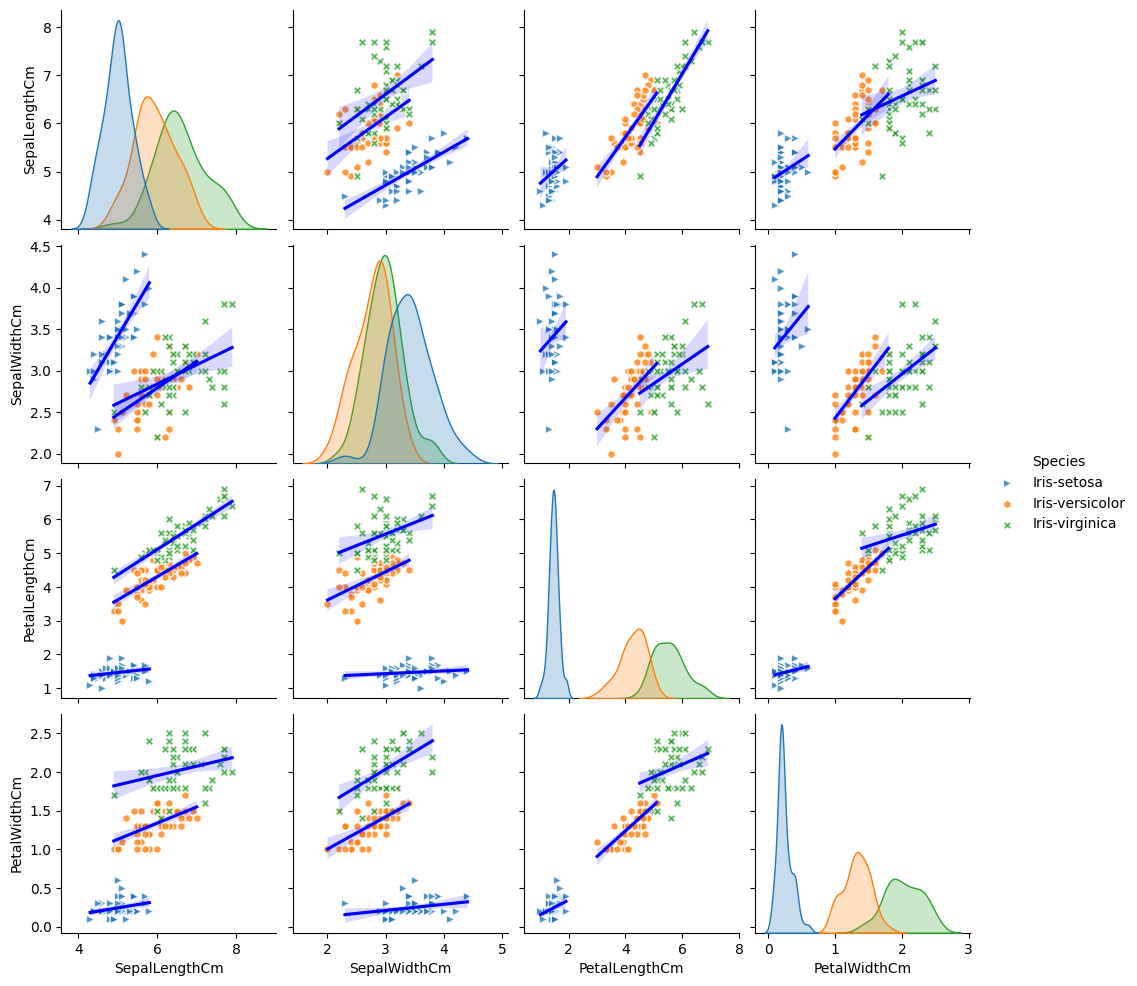

In [23]:
sns.pairplot(df, hue="Species", kind="reg", 
             plot_kws=dict(ci=95, x_ci="ci", line_kws=dict(color="b"), 
                           scatter_kws=dict(edgecolor="white")), 
             markers=class_markers)
plt.show()